# Touristic Tour Recommendation Application
This notebook outlines the steps involved in creating an algorithm that generates a one-week itinerary for tourists in Algeria. The itinerary is optimized based on user preferences, proximity, and travel costs. Various search techniques, including **Uninformed Search Algorithms**, **A*** and **Hill Climbing**, are employed to create the optimal itinerary.


## Data Collection & Research
We gathered - clean - data about **+200 Algerian tourist attractions**, including the following attributes:
- **Attraction Name**
- **Type of Attraction** (museum, nature, beach, etc.)
- **City**
- **Cost** (entry fee)
- **Rating** (user rating)
- **GPS Coordinates** (latitude, longitude)
- **Description** (short description)


In [15]:
import json
from collections import Counter

DATA_PATH = "../Data/attractions.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    attractions_data = json.load(f)
    

if not isinstance(attractions_data, list):
    raise ValueError("The JSON file does not contain a list of attractions.")

print("Number of attractions:", len(attractions_data))

# Count attractions per city
city_counts = Counter(attraction.get("city", "Unknown") for attraction in attractions_data)

# Count attractions per category
category_counts = Counter(attraction.get("category", "Unknown") for attraction in attractions_data)

print("\nNumber of attractions per city:")
for city, count in city_counts.items():
    print(f"{city}: {count}")

print("\nNumber of attractions per category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")


Number of attractions: 263

Number of attractions per city:
Algiers: 19
Tipaza: 5
Blida: 5
Médéa: 3
Oran: 16
Tlemcen: 9
Batna: 6
Béjaïa: 18
Constantine: 11
Djanet: 8
Sétif: 13
Annaba: 9
Guelma: 3
El Tarf: 7
Ghardaïa: 7
Tamanrasset: 7
Béchar: 3
Bouira: 7
El Bayadh: 1
Khenchela: 2
Biskra: 4
Timimoun: 6
El Oued: 2
M'Sila: 6
Tizi Ouzou: 21
Skikda: 6
Souk Ahras: 6
Tébessa: 6
Oum El-Bouaghi: 5
Jijel: 19
Aïn Témouchent: 10
Boumerdès: 5
Djelfa: 3
Naâma: 1
Mostaganem: 4

Number of attractions per category:
Garden: 5
Museum: 13
Cultural: 26
Historical: 49
Religious: 17
Amusement Park: 10
Shopping Mall: 5
Port: 2
Nature: 95
Lake: 6
Resort: 4
Beach: 30
Guest House: 1


### Hotel Data Handeling 
We also collected data on **hotels** in Algeria from various sources Cities .

In [16]:
import json
from collections import Counter

HOTELS_PATH = "../Data/cleaned_hotels.json"

with open(HOTELS_PATH, "r", encoding="utf-8") as f:
    hotels_data = json.load(f)

## Problem Formulation
### 1. State Representation

Our state representation is a dictionary with the following structure:

```python
state = {
    'current_location': (lat, lon),         # Current GPS coordinates
    'itinerary': [[] for _ in range(7)],    # 7 days of planned attractions (names)
    'curr_day': 0,                          # Current day index (0-6)
    'total_cost': 0,                        # Accumulated cost so far
    'total_time': 0,                        # Total travel time
    'daily_time': [0]*7                     # Time used per day (including visits)
    'daily_distance' : [0.0]*7
}
```

### 2. Actions

Two possible actions:
1. `('add', attraction)`: Add an attraction to the current day
2. `('next_day',)`: Move to the next day of planning

### 3. Goal Test

The goal is reached when:
- All 7 days have been planned (`curr_day >= 7`)
- Each day has at least one attraction

### 4. Path Cost

The path cost is the cumulative cost of visiting attractions and traveling between them.

### Problem Class
Now, let's define the main Problem class that will encapsulate our tour planning problem

In [ ]:
import math
import json
import random
import re
from copy import deepcopy
from typing import List, Dict, Tuple  # Helper library for type hinting

class TourPlanningProblem:
    def __init__(self, initial_state: Dict, attractions: List[Dict],
                 user_prefs: Dict, constraints: Dict):
        """
        Args:
            initial_state: Initial state dictionary.
            attractions: List of attraction dictionaries.
            user_prefs: User preferences dictionary.
            constraints: Problem constraints dictionary.
        """
        self.initial_state = initial_state
        self.attractions = attractions
        self.user_prefs = user_prefs
        self.constraints = constraints

        # cheaper if the user has a car
        self.dzd_per_km = 6.0 if constraints.get("has_car", False) else 10.0

        self.distance_cache = self._build_distance_cache()

    def _build_distance_cache(self) -> Dict[Tuple[str, str], float]:
        """Precompute distances between all pairs of attractions.
            store only upper‑triangle to halve the size"""
        cache = {}
        names = [a['name'] for a in self.attractions]
        for i, a1 in enumerate(self.attractions):
            for j in range(i + 1, len(self.attractions)):
                a2 = self.attractions[j]
                d = self._calculate_distance(a1['gps'], a2['gps'])
                cache[(a1['name'], a2['name'])] = d
                cache[(a2['name'], a1['name'])] = d          # mirror
        return cache

    @staticmethod
    def _calculate_distance(coord1: List[float], coord2: List[float]) -> float:
        """
        Haversine distance (km) between two GPS coordinates.
        """
        lat1, lon1 = map(math.radians, coord1)
        lat2, lon2 = map(math.radians, coord2)
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = (math.sin(dlat / 2)**2 +
             math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2)
        return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    def actions(self, state: Dict) -> List[Tuple]:
        """
        Return a list of possible actions from the current state.
        Two types of actions:
          - ('add', <attraction_dict>): add an attraction to the current day.
          - ('next_day',): move to the next day.
        """
        valid_actions = []
        curr_day = state['curr_day']

        # If all days are planned, no further actions
        if curr_day >= len(state['itinerary']):
            return []

        # If the current day is full, only allow moving to next day
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return [('next_day',)]

        preferred = set(self.user_prefs.get('categories', []))

        # Check each attraction for validity
        for att in self.attractions:
            if att['category'] not in preferred:                 # ← preference filter
                continue
            if self._is_valid_addition(state, att):
                valid_actions.append(('add', att))

        # Allow 'next_day' if there's at least one attraction in the current day
        if len(state['itinerary'][curr_day]) > 0:
            valid_actions.append(('next_day',))

        return valid_actions

    def _is_valid_addition(self, state: Dict, attraction: Dict) -> bool:
        curr_day = state['curr_day']
        if curr_day >= 7:
            return False

        # 1) duplicates & per-day limit
        if any(attraction['name'] in day for day in state['itinerary']):
            return False
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return False

        # 2) compute travel / visit metrics once
        distance_km  = self._calculate_distance(state['current_location'], attraction['gps'])
        travel_time  = distance_km / 50          # ← avg 50 km/h
        visit_time   = self._parse_duration(attraction['visit_duration'])
        ticket_cost  = self._parse_cost(attraction['cost'])
        travel_cost  = self.travel_cost_km(state['current_location'], attraction['gps'])

        # 3) global budget cap  (✓ Bug 2.1 fixed)
        budget_cap = self.constraints.get("max_total_budget")
        if budget_cap is not None:
            prospective = state['total_cost'] + ticket_cost + travel_cost
            if prospective > budget_cap:
                return False

        # 4) daily time cap
        if state['daily_time'][curr_day] + travel_time + visit_time > self.constraints['max_daily_time']:
            return False

        # 5) optional daily-distance cap  (✓ Bug 2.2 fixed)
        max_dist = self.constraints.get("max_daily_distance")
        if max_dist is not None:
            if state['daily_distance'][curr_day] + distance_km > max_dist:
                return False

        return True

    def _estimate_travel_time(self, state: Dict, new_attraction: Dict) -> float:
        """
        Estimate travel time from the last visited attraction (or current location)
        to the new attraction.
        Assumes an average speed of 50 km/h.
        """
        curr_day = state['curr_day']
        day_attractions = state['itinerary'][curr_day]

        if not day_attractions:
            last_coords = state['current_location']
        else:
            last_att_name = day_attractions[-1]
            last_att = next(a for a in self.attractions if a['name'] == last_att_name)
            last_coords = last_att['gps']

        distance = self._calculate_distance(last_coords, new_attraction['gps'])
        return distance / 50  # hours

    def result(self, state: Dict, action: Tuple) -> Dict:
        new_state = deepcopy(state)
        action_type = action[0]
        curr_day = new_state['curr_day']

        if action_type == 'add':
            _, attraction = action

            # compute distance between previous location and new attraction
            distance_km = self._calculate_distance(
                new_state['current_location'], attraction['gps']
            )
            # track daily distance
            new_state['daily_distance'][curr_day] += distance_km

            ticket_cost  = self._parse_cost(attraction['cost'])
            travel_cost  = self.travel_cost_km(new_state['current_location'], attraction['gps'])
            new_state['total_cost'] += ticket_cost + travel_cost

            # compute travel & visit durations
            travel_time = self._estimate_travel_time(state, attraction)
            visit_time  = self._parse_duration(attraction['visit_duration'])

            new_state['daily_time'][curr_day] += travel_time + visit_time
            new_state['total_time']           += travel_time + visit_time

            new_state['itinerary'][curr_day].append(attraction['name'])
            new_state['current_location'] = attraction['gps']

        elif action_type == 'next_day':
            new_state['curr_day'] += 1

        return new_state

    def path_cost(self, current_cost: float, state1: Dict,
                  action: Tuple, state2: Dict) -> float:
        """
        For every node, path_cost == state['total_cost'] (in dinars).
        We **never** add the leg cost here – `result()` has already done it.
        """
        return state2['total_cost']

    def travel_cost_km(self, gps_a: List[float], gps_b: List[float]) -> float:
        """Return travel money (DZD) between two points."""
        dist = self._calculate_distance(gps_a, gps_b)
        return dist * self.dzd_per_km

    def is_goal(self, state: Dict) -> bool:
        """
        The goal is reached if:
         1) We have planned all 7 days (curr_day >= 7).
         2) Each day has at least one attraction.
         3) The total cost is within budget.
        """
        if state['curr_day'] < 7:
            return False
        for day_list in state['itinerary']:
            if len(day_list) == 0:
                return False
        if state['total_cost'] > self.constraints['max_total_budget']:
            return False
        return True

    def value(self, state: Dict) -> float:
        """
        Higher is better.
          + satisfaction from preferred categories & ratings
          − cost/time penalties if caps were exceeded
        """
        # satisfaction ------------------------------------------------------
        base = self._calculate_satisfaction(state)      # 0-100 scale

        # penalties ---------------------------------------------------------
        over_budget = max(0.0, state['total_cost'] -
                          self.constraints.get('max_total_budget', float('inf')))
        cost_pen = (over_budget /
                    self.constraints.get('max_total_budget', 1)) * 100  # up to -100

        over_time = max(0.0, sum(state['daily_time']) -
                        7 * self.constraints['max_daily_time'])
        time_pen = (over_time /
                    (7 * self.constraints['max_daily_time'])) * 50       # cap -50

        return base - cost_pen - time_pen

    def _calculate_satisfaction(self, state: Dict) -> float:
        """Calculate user satisfaction score (0-100 scale)."""
        score = 0
        preferred_cats = set(self.user_prefs['categories'])
        for day in state['itinerary']:
            for att_name in day:
                attraction = next(a for a in self.attractions if a['name'] == att_name)
                if attraction['category'] in preferred_cats:
                    score += 10 * attraction['rating']
                else:
                    score += 5 * attraction['rating']
        max_possible = 10 * 5 * 7 * self.constraints['max_attractions_per_day']
        return (score / max_possible) * 100
    def _calculate_penalties(self, state: Dict) -> float:
        """Calculate penalty terms for constraints."""
        cost_penalty = (state['total_cost'] / self.constraints['max_total_budget']) * 50
        time_penalty = (sum(state['daily_time']) / (7 * self.constraints['max_daily_time'])) * 30
        return cost_penalty + time_penalty

    @staticmethod
    def _parse_cost(cost_str: str) -> float:
        """
        Convert cost field (e.g., "Free", "400 DZD", "Variable") to a numeric value.
        - "free" -> 0
        - "variable" or any non‑numeric -> 0
        - Otherwise, return the first number found.
        """
        s = cost_str.strip().lower()
        if "free" in s:
            return 0.0
        if "variable" in s:
            # treat Variable as zero cost, but later printed as "Variable", for e.g.: Shopping Malls (not implemented yet tho)
            return 0.0
        m = re.search(r"(\d+(?:\.\d+)?)", s)
        if m:
            return float(m.group(1))
        # fallback: everything else counts as zero
        return 0.0

    @staticmethod
    def _parse_duration(duration_str: str) -> float:
        """
        Convert a duration string (e.g., "1-2 hours", "0.5 hour", "3 hours") to a numeric estimate (hours).
        """
        duration_str = duration_str.lower().strip()
        # Matches "2 hours", "0.5 hour", "1-2 hours", etc.
        m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?\s*(?:h|hour|hrs?)", duration_str)
        if m:
            low = float(m.group(1))
            if m.group(2):
                high = float(m.group(2))
                return (low + high) / 2.0
            return low
        # Fallback if nothing matches
        return 2.0


### Node Class
First, let's define the Node class which will represent states in our search space:
A state represents a partial itinerary

In [ ]:
class Node:
    def __init__(self, state: Dict, parent: 'Node' = None, 
                 action: Tuple = None, path_cost: float = 0):
        """
        Args:
            state: The current state dictionary
            parent: Parent node
            action: Action that led to this node
            path_cost: Cumulative cost to reach this node
        """
        self.state = deepcopy(state)
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = parent.depth + 1 if parent else 0
        self.value = None  # Will store heuristic/objective value
        
    def __lt__(self, other: 'Node') -> bool:
        """
        For priority queue ordering if needed (like in A*).
        If self.value is None, defaults to 0 for comparison.
        """
        return self.value < other.value if self.value is not None else False
        
    def expand(self, problem: TourPlanningProblem) -> List['Node']:
        """Generate all child nodes reachable from this node"""
        child_nodes = []
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            child_node = Node(
                state=next_state,
                parent=self,
                action=action,
                path_cost=problem.path_cost(self.path_cost, self.state, action, next_state)
            )
            child_nodes.append(child_node)
        return child_nodes
        
    def path(self) -> List['Node']:
        """Return the path from root to this node"""
        node, path = self, []
        while node:
            path.append(node)
            node = node.parent
        return list(reversed(path))
        
    def __repr__(self) -> str:
        return (f"Node(day={self.state['curr_day']}, "
                f"cost={self.state['total_cost']}, "
                f"value={self.value})")
    
    def __eq__(self, other: 'Node') -> bool:
        """
        Equality check based on the state's itinerary and day.
        """
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self) -> int:
        """
        Hash based on the itinerary's arrangement for use in sets/dicts.
        """
        # We'll hash a tuple of (current_day, tuple of each day’s attractions).
        # This avoids collisions from dict ordering
        day_tuples = tuple(tuple(day) for day in self.state['itinerary'])
        return hash((self.state['curr_day'], day_tuples))
    def generate_neighbors(self, problem: 'TourPlanningProblem') -> List['Node']:
        """
        Generate all possible neighbors by swapping, removing, or adding attractions
        for each day of the itinerary, respecting the problem constraints.

        Args:
            problem (TourPlanningProblem): The problem instance that holds the data for attractions and constraints.

        Returns:
            List[Node]: A list of neighboring nodes.
        """
        neighbors = []
        current_state = self.state
        attractions = problem.attractions
        constraints = problem.constraints

        for day_idx in range(7):  # Iterate over the 7 days
            day = current_state['itinerary'][day_idx]

            # ---- SWAP Attractions within a Day ----
            if len(day) > 1:  # If more than one attraction for the day, we can swap
                for i in range(len(day)):
                    for j in range(i + 1, len(day)):
                        new_state = deepcopy(current_state)
                        new_day = new_state['itinerary'][day_idx]
                        new_day[i], new_day[j] = new_day[j], new_day[i]

                        # Find the actual attraction dictionaries based on the names
                        attraction_i = next((att for att in attractions if att['name'] == new_day[i]), None)
                        attraction_j = next((att for att in attractions if att['name'] == new_day[j]), None)

                        # Check if the new state is valid before creating a child node
                        if attraction_i and attraction_j and \
                        problem._is_valid_addition(new_state, attraction_i) and \
                        problem._is_valid_addition(new_state, attraction_j):
                            child_node = Node(
                                state=new_state,
                                parent=self,
                                action=("swap", day_idx, i, j),
                                path_cost=self.path_cost  # Update if cost changes
                            )
                            neighbors.append(child_node)

            # ---- REMOVE Attraction ----
            for i in range(len(day)):
                new_state = deepcopy(current_state)
                removed_name = new_state['itinerary'][day_idx].pop(i)

                removed_attr = next(a for a in attractions if a['name'] == removed_name)
                new_state['total_cost'] -= problem._parse_cost(removed_attr['cost'])
                new_state['daily_time'][day_idx] -= problem._parse_duration(removed_attr['visit_duration'])
                new_state['total_time'] -= problem._parse_duration(removed_attr['visit_duration'])  # Update total time

                # Check if the new state is valid after removal
                if new_state['total_cost'] <= constraints['max_total_budget']:
                    child_node = Node(
                        state=new_state,
                        parent=self,
                        action=("remove", day_idx, removed_name),
                        path_cost=self.path_cost  # Update if needed
                    )
                    neighbors.append(child_node)

            # ---- ADD a New Attraction ----
            for att in attractions:
                if att['name'] in current_state['itinerary'][day_idx]:
                    continue  # Avoid duplicates

                new_state = deepcopy(current_state)
                if problem._is_valid_addition(new_state, att):  # Check if addition is valid
                    new_state['itinerary'][day_idx].append(att['name'])
                    new_state['total_cost'] += problem._parse_cost(att['cost'])
                    travel_time = problem._estimate_travel_time(current_state, att)
                    visit_time = problem._parse_duration(att['visit_duration'])
                    new_state['daily_time'][day_idx] += travel_time + visit_time
                    new_state['total_time'] += travel_time + visit_time  # Update total time

                    # Check if the new state is valid after addition
                    if (new_state['daily_time'][day_idx] <= constraints['max_daily_time'] and
                        new_state['total_cost'] <= constraints['max_total_budget']):
                        child_node = Node(
                            state=new_state,
                            parent=self,
                            action=("add", day_idx, att['name']),
                            path_cost=self.path_cost  # Update if needed
                        )
                        neighbors.append(child_node)

        return neighbors
    def generate_random_solution(self, problem: 'TourPlanningProblem') -> dict:
        """
        Generate a random initial solution for the tour planning problem.

        Args:
            problem: The tour planning problem instance.

        Returns:
            A random state representing a potential solution.
        """
        random_state = {
            'curr_day': 0,
            'itinerary': [[] for _ in range(7)],
            'total_cost': 0.0,
            'total_time': 0.0,
            'daily_time': [0.0 for _ in range(7)],
            'current_location': problem.initial_state['current_location'],
        }

        used_attractions = set()
        max_daily_time = problem.constraints['max_daily_time']
        max_total_budget = problem.constraints['max_total_budget']
        max_attractions_per_day = problem.constraints['max_attractions_per_day']

        for day in range(7):
            day_time = 0.0
            day_cost = 0.0
            attractions_today = 0

            while day_time < max_daily_time and attractions_today < max_attractions_per_day:
                # Create a list of candidates that haven't been used yet
                candidates = [
                    att['name'] for att in problem.attractions
                    if att['name'] not in used_attractions 
                ]
                if not candidates:
                    break  # No more candidates available

                # Randomly select an attraction from the candidates
                selected_name = random.choice(candidates)
                selected_attraction = next(att for att in problem.attractions if att['name'] == selected_name)
                visit_time = problem._parse_duration(selected_attraction['visit_duration'])
                attraction_cost = problem._parse_cost(selected_attraction['cost'])

                # Check if adding this attraction exceeds the daily time limit or total budget
                if day_time + visit_time > max_daily_time or day_cost + attraction_cost > max_total_budget:
                    break

                # Update the random state with the selected attraction
                random_state['itinerary'][day].append(selected_name)
                used_attractions.add(selected_name)
                day_cost += attraction_cost
                day_time += visit_time
                random_state['daily_time'][day] += visit_time
                random_state['total_time'] += visit_time
                random_state['total_cost'] += attraction_cost
                random_state['current_location'] = selected_attraction['gps']  # Update current location
                attractions_today += 1  # Increment the count of attractions for today

        return random_state
    def get_best(self,neighbors_list: List['Node'], problem: 'TourPlanningProblem') -> Tuple['Node', float]:
        """
        Get the neighbor with the best (lowest) evaluation value.

        Args:
            neighbors_list: A list of Node instances.
            problem: Instance of TourPlanningProblem to evaluate nodes.

        Returns:
            A tuple of (best Node, its value)
        """
        best_value = float('-inf')
        best_node = None

        for node in neighbors_list:
            # Compute or retrieve value
            if node.value is None:
                node.value = problem.value(node.state)

            if node.value > best_value:
                best_value = node.value
                best_node = node

        return best_node, best_value




## Helper Functions

In [19]:
import math
from typing import List, Tuple, Dict
import json
def load_attractions(json_file: str) -> List[Dict]:
    """Load attractions from JSON file"""
    with open(json_file) as f:
        return json.load(f)

def create_initial_state(start_location: Tuple[float, float], user_prefs: Dict) -> Dict:
    """Create initial state dictionary"""
    return {
        'current_location': start_location,
        'itinerary': [[] for _ in range(7)],
        'curr_day': 0,
        'total_cost': 0.0,
        'total_time': 0.0,
        'daily_time': [0.0]*7,
        'daily_distance': [0.0]*7          # ← new
    }

def estimate_travel_time(distance_km: float,
                        transport_mode: str = 'car') -> float:
    """Convert distance to estimated travel time in hours"""
    speeds = {'car': 50, 'bus': 40, 'walking': 5}
    return distance_km / speeds.get(transport_mode, 50)

def calculate_day_time(itinerary_day: List[str],
                     attractions: List[Dict],
                     distance_matrix: Dict) -> float:
    """Calculate total time for a single day's itinerary"""
    total_time = 0
    for i in range(len(itinerary_day)):
        if i > 0:
            prev_att = next(a for a in attractions if a['name'] == itinerary_day[i-1])
            curr_att = next(a for a in attractions if a['name'] == itinerary_day[i])
            distance = distance_matrix[(prev_att['name'], curr_att['name'])]
            total_time += estimate_travel_time(distance)
        # Note: to be adjusted if we need to look up the visit duration for the current attraction
        total_time += TourPlanningProblem._parse_duration(curr_att['visit_duration'])
    return total_time

def calculate_total_cost(itinerary: List[List[str]],
                       attractions: List[Dict]) -> float:
    """Calculate total cost of itinerary"""
    return sum(TourPlanningProblem._parse_cost(a['cost'])
              for day in itinerary
              for att_name in day
              for a in attractions if a['name'] == att_name)

def estimate_hotel_costs(hotel_standard: Tuple[int, int],
                        num_nights: int = 7) -> float:
    """Estimate hotel costs based on preferred star rating"""
    min_stars, max_stars = hotel_standard
    avg_stars = (min_stars + max_stars) / 2
    # Assuming 3000 DZD per night per star
    return avg_stars * 3000 * num_nights


def find_suitable_hotels(day_attractions, hotels_data, min_stars, max_stars, remaining_budget):
    """
    Find suitable hotels for a day's itinerary.
    Returns list of hotels and total cost.
    """
    if not day_attractions:
        return [], 0

    # Get all cities from the day's attractions
    cities = set()
    for att_name in day_attractions:
        attraction = next(a for a in attractions_data if a['name'] == att_name)
        cities.add(attraction['city'])

    # Filter hotels by cities and star rating
    suitable_hotels = []
    for hotel in hotels_data:
        if (hotel['city'] in cities and
            min_stars <= hotel['average review'] <= max_stars and
            hotel['price'] <= remaining_budget):
            suitable_hotels.append(hotel)

    # Sort by price (ascending)
    suitable_hotels.sort(key=lambda x: x['price'])

    # Take top 3 cheapest
    selected_hotels = suitable_hotels[:3]
    total_cost = sum(h['price'] for h in selected_hotels)

    return selected_hotels, total_cost


## User Preferences Simulation 
The application will take inputs (from the website interface) such as:
- **Starting location**: Algiers
- **Preferred attractions**: Museums, Historical Sites
- **Budget**: 5000 DZD
- **Hotel rating**: 3 stars (Suggested :  add a MAX and MIN for the hotel rating)


## Search Algorithm Implementations

In this project, we use a combination of **uninformed search algorithms** (BFS, DFS) and **informed search algorithms** (A\* Search, Hill Climbing) to generate the optimal itinerary based on cost, proximity, and user preferences.

Each search algorithm has its strengths and weaknesses. In this section, we will implement and compare their performance in solving the itinerary optimization problem.


### DFS
Explores each path as deep as possible before backtracking, often used when exploring solutions in a depth-first manner.

In [20]:
def depth_limited_search(problem: TourPlanningProblem, limit: int):
    """
    A Depth-Limited Search on the TourPlanningProblem.

    :param problem: An instance of the TourPlanningProblem.
    :param limit: Maximum depth (or 'depth limit') for the search.
    :return: The first solution Node that satisfies problem.is_goal(...) or None if no solution is found
             within the specified depth limit.
    """
    # We'll define a recursive inner function that carries the explored set and the current depth as we go deeper.
    def recursive_dls(node: Node, depth: int, explored):
        if problem.is_goal(node.state):
            return node

        if depth == limit:
            return None  # We've reached the depth limit, stop going deeper.

        explored.add(node)

        # Expand the node
        for child in node.expand(problem):
            if child not in explored:
                result = recursive_dls(child, depth + 1, explored)
                if result is not None:
                    return result
        return None

    initial_node = Node(problem.initial_state)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored_set = set()

    return recursive_dls(initial_node, 0, explored_set)


def depth_first_search(problem: TourPlanningProblem, max_depth: int = None):
    """
    Depth-First Search for the TourPlanningProblem.
    If max_depth is None, we use a very large limit (effectively 'no limit').
    """
    if max_depth is None:
        max_depth = 999999  # effectively no limit

    return depth_limited_search(problem, max_depth)

def iterative_deepening_search(problem: TourPlanningProblem, max_depth: int = 30):
    """
    Iterative Deepening DFS: Repeatedly run depth-limited DFS up to increasing depth limits.

    :param problem: An instance of TourPlanningProblem.
    :param max_depth: Maximum depth up to which we'll attempt searches.
    :return: The first solution Node found, or None if no solution is found up to max_depth.
    """
    for depth in range(max_depth + 1):
        result = depth_limited_search(problem, depth)
        if result is not None:
            return result
    return None

### Example Executing DFS

In [21]:
def run_DFS_demo() -> None:
    """Depth‑first demo"""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,          # cheaper per‑km rate
    }
    user_prefs = {"categories": ["Beach", "Historical", "Museum", "Shopping Mall"]}

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # 2. build problem & search
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = depth_first_search(problem, max_depth=40)
    if goal is None:
        print("DFS ❌  No itinerary found within the depth limit.")
        return

    # 3. pretty trace of the path
    print("DFS ✅  itinerary found\n")
    path = goal.path()            # root … goal
    running_cost = 0.0
    day_cost     = 0.0
    day          = 1
    here_coords  = initial_state["current_location"]

    print(f"🏁  Start in {here_coords}\n")

    for node in path[1:]:         # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km   = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost     += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att['name']}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal‑day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0
            # keep `here_coords` unchanged (we wake up where we ended)

    # print last‑day footer if goal node wasn’t a next_day
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_total_dz = sum(problem._parse_cost(a["cost"])
                           for a in attractions_data
                           if a["name"] in lst)  # tickets only
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_total_dz:4.0f} DZD  ->  {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage  : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱  Search depth   : {goal.depth}")


# quick test
if __name__ == "__main__":
    run_DFS_demo()

DFS ✅  itinerary found

🏁  Start in (36.737232, 3.086472)

  ➜  Day 1 · Bardo Museum
      travel     3.9 km  =     24 DZD
      ticket                  300 DZD
      subtotal‑day            324 DZD   │  grand    324 DZD

  ➜  Day 1 · Casbah of Algiers
      travel     2.3 km  =     14 DZD
      ticket                    0 DZD
      subtotal‑day            338 DZD   │  grand    338 DZD

  ➜  Day 1 · Martyrs' Memorial (Maqam Echahid)
      travel     1.5 km  =      9 DZD
      ticket                    0 DZD
      subtotal‑day            346 DZD   │  grand    346 DZD

—— End of Day 1  •  daily total 346 DZD ——

  ➜  Day 2 · Beb Ezzouar Shopping Mall
      travel    11.5 km  =     69 DZD
      ticket                    0 DZD
      subtotal‑day             69 DZD   │  grand    415 DZD

  ➜  Day 2 · Musée des Beaux-Arts d'Alger
      travel     9.9 km  =     59 DZD
      ticket                  200 DZD
      subtotal‑day            328 DZD   │  grand    675 DZD

  ➜  Day 2 · National Museu

## UCS

Explores the least-cost path first using a priority queue based on path cost.

In [22]:
import heapq
from typing import Dict, Tuple

def uniform_cost_search(problem: TourPlanningProblem) -> Node:
    """
    Perform Uniform Cost Search (UCS) to find an optimal itinerary.

    :param problem: An instance of the TourPlanningProblem.
    :return:        The solution Node if found, otherwise None.
    """
    root = Node(problem.initial_state, path_cost=0.0)

    frontier = []                                           # (cost, tie-id, node)
    heapq.heappush(frontier, (0.0, id(root), root))

    # Best monetary cost discovered so far for *this* itinerary state
    best_cost: Dict[Tuple, float] = {state_to_key(root.state): 0.0}

    while frontier:
        cost_so_far, _, node = heapq.heappop(frontier)

        # Discard paths that are already dominated by something cheaper
        if cost_so_far > best_cost[state_to_key(node.state)]:
            continue

        # Goal test
        if problem.is_goal(node.state):
            return node

        # Expand children
        for child in node.expand(problem):
            key       = state_to_key(child.state)
            new_cost  = child.path_cost           # ← already cumulative

            if key not in best_cost or new_cost < best_cost[key]:
                best_cost[key] = new_cost
                child.value   = new_cost          # (nice for pretty __lt__)
                heapq.heappush(frontier, (new_cost, id(child), child))

    return None                                   # No feasible itinerary

# Helper – hashable representation of a state
def state_to_key(state: Dict) -> Tuple:
    """
    Create a consistent, hashable key for state comparison.

    NOTE 3.1 fix
    ------------
    We *add* the **rounded total_cost** to the key, so two states that visit
    the same places in the same order but spend different amounts of money
    are treated as distinct.  This prevents an expensive path from
    accidentally pruning a cheaper one (or vice-versa).

    We round to the nearest dinar (0 decimals) – feel free to change the
    precision if your currency dictates otherwise.
    """
    return (
        round(state['current_location'][0], 6),          # lat
        round(state['current_location'][1], 6),          # lon
        tuple(tuple(day) for day in state['itinerary']), # 7-day matrix
        state['curr_day'],                               # 0 … 6
        round(state['total_cost'], 0),                   # ← NEW field
    )


### Example using UCS

In [ ]:
def run_UCS() -> None:
    """Uniform‑Cost demo."""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,          # 6 DZD / km instead of 10
    }
    user_prefs = {"categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"]}

    initial_state = {
        "current_location": (36.90285900,7.75554300),   # Annaba
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # 2. build problem & search
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = uniform_cost_search(problem)
    if goal is None:
        print("UCS ❌  No itinerary found (budget or depth limit).")
        return

    # 3. pretty trace of the itinerary
    print("UCS ✅  cost‑optimal itinerary found (w.r.t. money only)\n")
    path = goal.path()            # root … goal
    running_cost = 0.0
    day_cost     = 0.0
    day          = 1
    here_coords  = initial_state["current_location"]

    print(f"🏁  Start in  {here_coords}\n")

    for node in path[1:]:         # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]

            dist_km   = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost     += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att['name']}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal‑day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    # print last‑day footer if the tour ends with an ‘add’
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_tickets:4.0f} DZD  ->  {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage  : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱  Search nodes expanded : {goal.depth}")


# quick test
if __name__ == "__main__":
    run_UCS()

### BFS
Explores all paths at the current depth before moving on to the next level, ensuring the shortest path is found if the graph is unweighted.


In [ ]:
from collections import deque

def BFS(problem, hotels_data, attractions_data):
    """
    BFS that suggests hotels each day based on visited cities and user preferences.
    """
    frontier = deque()
    initial_node = Node(problem.initial_state)
    frontier.append(initial_node)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored = set()
    frontier_states = {compact_hash(initial_node.state)}
    iterations = 0

    while frontier:

        node = frontier.popleft()
        state_hashable = compact_hash(node.state)

        if state_hashable in explored:
            continue

        iterations += 1
        explored.add(state_hashable)
        frontier_states.discard(state_hashable)

        for child in node.expand(problem):
            child_hashable = compact_hash(child.state)

            if child_hashable in explored or child_hashable in frontier_states:
                continue

            # --- 🔥 HOTEL SUGGESTION LOGIC START ---
            itinerary = child.state.get('itinerary', [])
            curr_day = child.state.get('curr_day')
            budget = child.state.get('budget', 0)
            preferences = child.state.get('preferences', {})
            hotel_stars = preferences.get('hotel_stars', (3, 5))

            day_attractions = itinerary[curr_day] if curr_day < len(itinerary) else []
            selected_hotels, total_hotel_cost = find_suitable_hotels(
                day_attractions=day_attractions,
                hotels_data=hotels_data,
                min_stars=hotel_stars[0],
                max_stars=hotel_stars[1],
                remaining_budget=budget - child.state.get('total_cost', 0)
            )

            # Update state if hotels were found
            if selected_hotels:
                child.state['hotels'] = child.state.get('hotels', {})
                child.state['hotels'][curr_day] = selected_hotels

                # Update cost
                child.state['total_cost'] += total_hotel_cost
            # --- 🔥 HOTEL SUGGESTION LOGIC END ---

            if problem.is_goal(child.state):
                print(f"BFS ✅ Goal found after {iterations} expansions.")
                return child

            frontier.append(child)
            frontier_states.add(child_hashable)

    print(f"BFS ❌ Exhausted frontier after {iterations} iterations.")
    return None



def compact_hash(state):
    """
    Converts the state into a completely hashable form by recursively
    converting dicts, lists, and sets into tuples.
    """
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(v) for v in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(v) for v in value))
        else:
            return value

    return (
        make_hashable(state.get('current_location')),
        state.get('curr_day'),
        make_hashable(state.get('itinerary')),
        make_hashable(state.get('daily_time')),
        round(state.get('total_cost', 0.0), 2),
        round(state.get('total_time', 0.0), 2),
        make_hashable(state.get('preferences', {})),
    )


### BFS Example


In [ ]:
def run_BFS() -> None:
    """Breadth‑First demo (shortest‑depth)."""
    # ── 1 • scenario settings ────────────────────────────────────────────────
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 2,
        "has_car": True,                  # 6 DZD / km
    }
    user_prefs = {"categories": ["Museum"]}

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # ── 2 • build problem & run BFS (depth‑minimal) ──────────────────────────
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = BFS(problem,hotels_data,attractions_data)
    if goal is None:
        print("BFS ❌  No itinerary found (budget / depth cap).")
        return

    # ── 3 • Display itinerary with hotel suggestions ─────────────────────────────
    print("BFS ✅ depth-optimal itinerary found\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]
    hotels_by_day = goal.state.get("hotels", {})

    print(f"Start in {here_coords}\n")

    for node in path[1:]:  # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * (6 if constraints.get("has_car") else 10)
            ticket_dz = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att['name']}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——")

            # ✅ Show hotels stored during BFS
            hotels = hotels_by_day.get(day - 1, [])
            if hotels:
                print(" Hotel suggestions for tonight:")
                for hotel in hotels[:3]:  # show top 3
                    print(f"     • {hotel['name']} ({hotel['city']}) - {hotel['price']} DZD/night")
            else:
                print(" No suitable hotels found for this day.")
            print()

            day += 1
            day_cost = 0.0

    # Final day footer
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——")
        hotels = hotels_by_day.get(day - 1, [])
        if hotels:
            print(" Hotel suggestions for tonight:")
            for hotel in hotels[:3]:
                print(f"     • {hotel['name']} ({hotel['city']}) - {hotel['price']} DZD/night")
        else:
            print(" No suitable hotels found for this day.")
        print()



    # ── 4 • summaries ────────────────────────────────────────────────────────
    st = goal.state
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {tickets:4.0f} DZD  ->  {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage  : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱  Search depth (solution length) : {goal.depth}\n")


# quick test
if __name__ == "__main__":
    run_BFS()

BFS ✅  Goal found after 10958 expansions.
BFS ✅  depth‑optimal itinerary found

🏁  Start in  (36.737232, 3.086472)

  ➜  Day 1 · Bardo Museum
      travel     3.9 km  =     24 DZD
      ticket                  300 DZD
      subtotal‑day            324 DZD   │  grand    324 DZD

—— End of Day 1  •  daily total 324 DZD ——

  ➜  Day 2 · Musée des Beaux-Arts d'Alger
      travel     2.4 km  =     14 DZD
      ticket                  200 DZD
      subtotal‑day            214 DZD   │  grand    538 DZD

—— End of Day 2  •  daily total 214 DZD ——

  ➜  Day 3 · National Museum of Antiquities of Algiers
      travel     3.1 km  =     18 DZD
      ticket                  200 DZD
      subtotal‑day            218 DZD   │  grand    756 DZD

—— End of Day 3  •  daily total 218 DZD ——

  ➜  Day 4 · Villa Abd-el-Tif
      travel     3.0 km  =     18 DZD
      ticket                  150 DZD
      subtotal‑day            168 DZD   │  grand    925 DZD

—— End of Day 4  •  daily total 168 DZD ——

  ➜  Da

### A\*
Uses a heuristic to optimize the search process by combining the current cost with the estimated cost to reach the goal.

In [ ]:
import heapq
from typing import Dict, Tuple


def a_star_search(problem: "TourPlanningProblem") -> "Node":
    """
    A* that **minimises money** while **guaranteeing** that every empty day
    will eventually receive at least one attraction.

    ─────────────────────────────────────────────────────────────────────────
    Cost terms
    ----------
    g(n)  =   node.path_cost
              (the cumulative DZD that `problem.result` has already added)

    h(n)  =   missing-day lower bound  (see the helper function below)

    f(n)  =   g(n) + h(n)              (classic, cost-only A*)

    ─────────────────────────────────────────────────────────────────────────
    Why this `h(n)` is *admissible* and *consistent*
    ------------------------------------------------
    •  *Admissible* – for every still-empty day we add the **cheapest ticket
       price in the entire data set** and assume ZERO travel cost.  
       → actual future spending will be ≥ our estimate.

    •  *Consistent* – when we add an attraction to an empty day:

          Δh = − cheapest_ticket
          Δg =   ticket_cost  ( ≥ cheapest_ticket )

       so  Δf = Δg + Δh  ≥ 0.                                   □
    """
    # 0. root
    root = Node(problem.initial_state, path_cost=0.0)
    h_root = missing_day_lower_bound(problem, root.state)
    frontier = [(root.path_cost + h_root, id(root), root)]     # (f, tie-id, node)

    best_g: Dict[Tuple, float] = {_state_to_key(root.state): 0.0}

    # 1. main loop
    while frontier:
        f_curr, _, node = heapq.heappop(frontier)
        sig = _state_to_key(node.state)

        # dominated?
        if node.path_cost > best_g[sig]:
            continue

        # goal test
        if problem.is_goal(node.state):
            return node

        # expand children
        for child in node.expand(problem):
            g = child.path_cost
            h = missing_day_lower_bound(problem, child.state)
            f = g + h
            c_sig = _state_to_key(child.state)

            if c_sig not in best_g or g < best_g[c_sig]:
                best_g[c_sig] = g
                heapq.heappush(frontier, (f, id(child), child))

    return None   # no feasible itinerary found


#  HEURISTIC  –  minimal money still required to make every day non-empty
def missing_day_lower_bound(problem: "TourPlanningProblem", state: Dict) -> float:
    """
    Returns   (# of completely empty days still ahead) × (minimum ticket price)

    This is a *lower* bound on future spending – travel costs are ignored
    and we assume we can always pick the very cheapest attraction.
    """
    # compute once and store on the function object (cheap global cache)
    if not hasattr(missing_day_lower_bound, "_cheapest_ticket"):
        prices = [
            problem._parse_cost(att["cost"])
            for att in problem.attractions
        ]
        # if everything is free (unlikely) → bound is zero
        missing_day_lower_bound._cheapest_ticket = max(0.0, min(prices, default=0.0))

    cheapest = missing_day_lower_bound._cheapest_ticket

    # count days that are *still completely empty*
    empty_days = sum(
        1
        for day_idx in range(state["curr_day"], 7)
        if len(state["itinerary"][day_idx]) == 0
    )

    return empty_days * cheapest


#  HASHABLE STATE SIGNATURE  (unchanged from earlier UCS fix)
def _state_to_key(state: Dict) -> Tuple:
    """Rounded GPS + itinerary + day index + rounded money → stable hash."""
    return (
        round(state['current_location'][0], 6),
        round(state['current_location'][1], 6),
        tuple(tuple(day) for day in state['itinerary']),
        state['curr_day'],
        round(state['total_cost'], 0),
    )


### Exmaple using A* Search 

In [ ]:
def run_a_star_demo() -> None:
    """A* demo (money-optimal with admissible heuristic)."""
    # 1. scenario settings 
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 9.0,
        "max_attractions_per_day": 6,
        "has_car": True,                      # 6 DZD / km
    }
    user_prefs = {
        "categories": [
            "Garden", "Museum", "Cultural", "Historical", "Religious",
            "Amusement Park", "Shopping Mall", "Port", "Nature",
            "Lake", "Resort", "Beach"
        ]
    }

    initial_state = {
        "current_location": (36.74573681325558, 3.0696590168649642),  # Maqam Echahid
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        "daily_distance": [0.0] * 7,
    }

    # 2. build problem & run A*
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = a_star_search(problem)
    if goal is None:
        print("A* ❌  No itinerary found (likely heuristic/budget issue).")
        return

    # 3. pretty trace
    print("A* ✅  cost-optimal itinerary found\n")
    path           = goal.path()             # root … goal
    running_cost   = 0.0
    day_cost       = 0.0
    day            = 1
    here_coords    = initial_state["current_location"]

    print(f"🏁  Start in {here_coords}\n")

    for node in path[1:]:                    # skip root
        act = node.action
        if act[0] == "add":
            att        = act[1]
            dist_km    = problem._calculate_distance(here_coords, att["gps"])
            travel_dz  = dist_km * problem.dzd_per_km
            ticket_dz  = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost     += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att['name']}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
            day_cost  = 0.0
            day      += 1
            # here_coords unchanged – we wake up where we ended

    # Last-day footer if itinerary ends with an “add”
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries 
    st = goal.state
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(
            f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
            f"tickets ≈ {tickets:4.0f} DZD  ->  {lst}"
        )

    print(
        "\nGrand total spent : "
        f"{st['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)"
    )
    print(
        "Daily time usage  : "
        + ", ".join(f"{h:4.1f} h" for h in st["daily_time"])
    )
    print(f"⏱  Search depth (solution length) : {goal.depth}\n")


# quick smoke-test
if __name__ == "__main__":
    run_a_star_demo()

A* ✅  cost-optimal itinerary found

🏁  Start in (36.74573681325558, 3.0696590168649642)

  ➜  Day 1 · Martyrs' Memorial (Maqam Echahid)
      travel     3.2 km  =     19 DZD
      ticket                    0 DZD
      subtotal-day             19 DZD   │  grand     19 DZD

—— End of Day 1  •  daily total 19 DZD ——

  ➜  Day 2 · La Grande Poste d'Alger
      travel     1.1 km  =      6 DZD
      ticket                    0 DZD
      subtotal-day              6 DZD   │  grand     25 DZD

—— End of Day 2  •  daily total 6 DZD ——

  ➜  Day 3 · Casbah of Algiers
      travel     1.2 km  =      7 DZD
      ticket                    0 DZD
      subtotal-day              7 DZD   │  grand     33 DZD

—— End of Day 3  •  daily total 7 DZD ——

  ➜  Day 4 · Ketchaoua Mosque
      travel     0.1 km  =      0 DZD
      ticket                    0 DZD
      subtotal-day              0 DZD   │  grand     33 DZD

—— End of Day 4  •  daily total 0 DZD ——

  ➜  Day 5 · Palais des Raïs
      travel     0.5

### Hill-Climbing
A simple greedy approach that evaluates only the immediate next state and chooses the best option available without considering future paths.

In [ ]:

def hill_climbing(problem: TourPlanningProblem):
        """
        Perform Hill Climbing to find the optimal path based on local evaluations.
        
        Args:
        - start: Starting location.
        - attractions: List of all attractions.
        - distance_function: Function to calculate distance.
        - heuristic_function: Function to evaluate the "goodness" of a path.
        - maybe more, depends on the one implementing the algorithm
        
        Returns:
        - List of attractions in the path, or None if no solution is found.
        """
        # Create an initial node with the initial state
        initial_node = Node(problem.initial_state)  # Create a Node instance with the initial state

        # Generate a random solution using the Node's method
        random_state = initial_node.generate_random_solution(problem) 
        print(random_state) 
        current_node = Node(random_state)  
        current_node.value = problem.value(current_node.state)

        print(f"Initial Solution Value: {current_node.value}")
        

        while True:
            
            neighbors_states = current_node.generate_neighbors(problem)  # Use instance method to generate neighbors
            if not neighbors_states:
                print("No neighbors found, ending search.")
                break

            # Find the best neighbor
            best_neighbor, best_value = current_node.get_best(neighbors_states, problem)

            # If no better neighbor is found, exit the loop
            if best_value < current_node.value:
                print("No better neighbors found, ending search.")
                break

            # Move to the best neighbor
            current_node = best_neighbor  
            print(f"New Current Node Value: {current_node.value}")
            print(current_node.state)

        return current_node.state, current_node.value


### Example using Hill Climbing

In [ ]:
def run_hill_climbing_demo():
    # Define constraints
    constraints = {
        'max_total_budget': 5000.0,
        'max_daily_time': 7.0,
        'max_attractions_per_day': 1
    }

    user_prefs = {
        'categories': ['Museum', 'Historical', 'Nature']
    }

    # Initialize initial state with default values
    initial_state = {
        'current_location': (35.6911, -0.6417),  # e.g., Oran coordinates
        'itinerary': [[] for _ in range(7)],
        'curr_day': 0,
        'total_cost': 0.0,
        'total_time': 0.0,
        'daily_time': [0.0] * 7,
    }

    # Initialize problem instance
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints
    )

    # Generate a random initial solution
    #problem.initial_state = problem.generate_random_solution()

    # Run Hill Climbing search
    solution_node, solution_value = hill_climbing(problem)

    if solution_node is None:
        print("Hill Climbing: No solution found.")
    else:
        print("Hill Climbing found a solution!\n")
        final_state = solution_node

        # Print itinerary
        for d, day_list in enumerate(final_state['itinerary']):
            print(f"Day {d + 1}: {day_list}")

        print(f"\nTotal cost: {final_state['total_cost']:.2f} DA")
        print("Daily time usage:")
        for i, t in enumerate(final_state['daily_time'], 1):
            print(f"  Day {i}: {t:.2f} hours")

if __name__ == "__main__":
    run_hill_climbing_demo()

Hill‑Climbing ✅  greedy high‑satisfaction itinerary

🏁  Start in  (36.902859, 7.755543)

  ➜  Day 1 · Farouk Land
      travel    4.5 km  =     27 DZD
      ticket           =    100 DZD
      ── day‑subtotal  =    127 DZD   │ total =    127 DZD

  ➜  Day 1 · Emir Abdelkader Mosque
      travel  116.3 km  =    698 DZD
      ticket           =      0 DZD
      ── day‑subtotal  =    825 DZD   │ total =    825 DZD

────────────  End of Day 1  (subtotal 825 DZD) ────────────

  ➜  Day 2 · Ancient Villages Aourir and Moknea
      travel  197.4 km  =   1184 DZD
      ticket           =      0 DZD
      ── day‑subtotal  =   1184 DZD   │ total =   2009 DZD

────────────  End of Day 2  (subtotal 1184 DZD) ────────────

  ➜  Day 3 · M'Zab Valley
      travel  470.3 km  =   2822 DZD
      ticket           =      0 DZD
      ── day‑subtotal  =   2822 DZD   │ total =   4831 DZD

────────────  End of Day 3  (subtotal 2822 DZD) ────────────

  ➜  Day 4 · Grande Mosquée de Ghardaïa
      travel    2.6

## CSP Approach
We model the itinerary planning as a **Constraint Satisfaction Problem (CSP)**. Each attraction represents a variable, and the domain of each variable is the set of attractions that can be visited. Constraints include:
  1. **One destination per day**: Each day gets exactly one destination.
  2. **Proximity and time**: Destinations must be scheduled in a way that minimizes travel time and adheres to time constraints.
  3. **Cost**: The total cost of the trip should be within the user’s budget.
  4. **Preferences**: Ensure that the user’s preferences for types of attractions are respected.


In [ ]:
# Define constraints for the CSP
def check_constraints(itinerary, user_preferences):
    pass


## Comparative Evaluation of Algorithms 

We will compare the performance of the following search algorithms:

1. **BFS**: Guarantees the shortest path but may be slow for large datasets.
2. **DFS**: Fast but not guaranteed to find the optimal solution.
3. **A\***: Combines optimality with efficiency when the heuristic is accurate.
4. **Hill Climbing**: Greedy and fast but may get stuck in local optima.
5. **CSP Approach**: Will compare the CSP solution with the search-based methods.

We will evaluate the following metrics:
- **Execution time**: How long each algorithm takes to generate the itinerary.
- **Path optimality**: How close the solution is to the optimal itinerary in terms of cost, proximity, and user satisfaction.
- **Complexity**: The computational complexity of each approach.


Running algorithm comparisons...
Running DFS...
Running Uniform Cost...
Running A*...
Running Hill Climbing...

=== Comparative Analysis Results ===


,Time (s),Total Cost,Days Used,Satisfaction,Penalties,Value
Algorithm,,,,,,
DFS,0.046691,4932.374954,7,41.666667,76.228698,-34.562032
Uniform Cost,167.343383,156.873602,7,15.095238,12.475112,2.620126
A*,0.438226,4999.818583,7,14.952381,67.140821,-52.188440
Hill Climbing,0.045275,1570.377302,6,31.523810,30.838929,0.684881


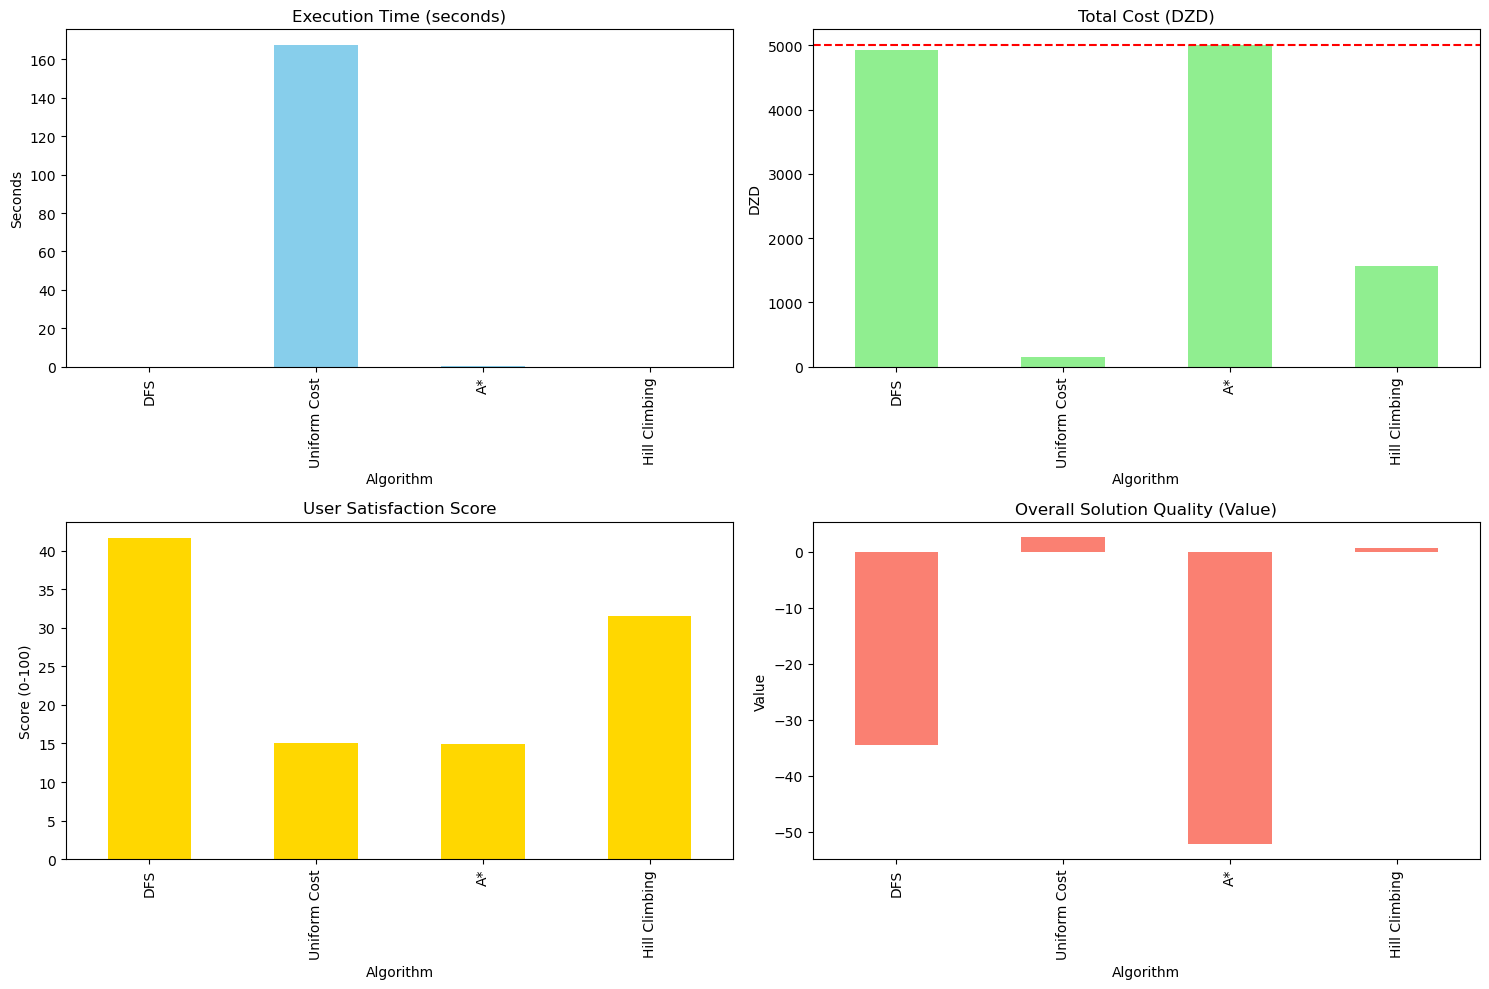


=== Algorithm Complexity Analysis ===


,Time Complexity,Space Complexity,Optimal,Complete
Algorithm,,,,
BFS,O(b^d),O(b^d),Yes,Yes
DFS,O(b^m),O(bm),No,No
Iterative Deepening,O(b^d),O(bd),Yes,Yes
Uniform Cost,O(b^(1+C/ε)),O(b^(1+C/ε)),Yes,Yes
A*,O(b^d),O(b^d),Yes,Yes
Hill Climbing,O(n),O(1),No,No



=== Strengths and Weaknesses ===


,Strengths,Weaknesses,Best Use Case
BFS,"Guarantees optimal solution, complete","High memory usage, slow for large problems",Small problems where optimality is critical
DFS,"Low memory usage, fast for some problems","Not optimal, may get stuck in deep paths",When memory is constrained and solution depth ...
Iterative Deepening,Optimal like BFS but with better memory usage,Repeats work at each iteration,When solution depth is unknown but optimality ...
Uniform Cost,"Optimal for path cost, good for weighted graphs",Higher memory usage than greedy algorithms,When costs vary significantly between steps
A*,Optimal and efficient with good heuristic,Requires domain-specific heuristic,When you have a good heuristic function
Hill Climbing,"Very fast, low memory usage","Gets stuck in local optima, not optimal",Large problems where a good-enough solution is...



=== Final Recommendations ===
1. For small problems (<50 attractions): BFS or Iterative Deepening
2. For medium problems with good heuristic: A*
3. For large problems where optimality isn't critical: Hill Climbing
4. When memory is constrained: DFS or Hill Climbing
5. When costs vary significantly: Uniform Cost Search


In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import numpy as np

def run_algorithm(algorithm, problem):
    """Run an algorithm and measure its performance metrics."""
    start_time = time.time()

    # Define a wrapper to correctly call the algorithm with proper args
    def wrapped_algo():
        if algorithm.__name__ == 'BFS':
            return algorithm(problem,hotels_data,attractions_data)
        elif algorithm.__name__ in ['depth_first_search', 'iterative_deepening_search']:
            return algorithm(problem, max_depth=40)
        elif algorithm.__name__ == 'hill_climbing':
            initial_node = Node(problem.initial_state)
            return algorithm(problem, initial_node)
        else:
            return algorithm(problem)

    # Profile memory usage
    mem_usage = memory_usage((wrapped_algo,), interval=0.1)
    avg_mem = sum(mem_usage) / len(mem_usage)
    max_mem = max(mem_usage)


    solution = wrapped_algo()
    exec_time = time.time() - start_time

    if solution:
        return {
            'solution': solution,
            'time': exec_time,
            'avg_memory': avg_mem,
            'max_memory': max_mem,
            'cost': solution.state['total_cost'],
            'days_used': solution.state['curr_day'],
            'satisfaction': problem._calculate_satisfaction(solution.state),
            'penalties': problem._calculate_penalties(solution.state),
            'value': problem.value(solution.state),
            'nodes_expanded': getattr(solution, 'nodes_expanded', None),
            'frontier_size': getattr(solution, 'max_frontier', None)
        }
    return None


def compare_algorithms(attractions_data):
    """Compare multiple algorithms for the tour planning problem."""
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 1,
        "has_car": True,                  # 6 DZD / km
    }
    user_prefs = {"categories": ["Museum"]}

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # ── 2 • build problem & run BFS (depth‑minimal) ──────────────────────────
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints
    )
# A* will be added later once done
    algorithms = [
        ('DFS', depth_first_search),
        ('Uniform Cost', uniform_cost_search),
        ('BFS', BFS),
        ('itirative deepening',iterative_deepening_search),
        ('Hill Climbing', hill_climbing)

    ]

    results = []
    print("Running comparisons...")
    for name, algo in algorithms:
        print(f"\n{name}...")
        result = run_algorithm(algo, problem)
        if result:
            results.append({
                'Algorithm': name,
                'Time (s)': result['time'],
                'Avg Memory (MB)': result['avg_memory'],
                'Max Memory (MB)': result['max_memory'],
                'Total Cost': result['cost'],
                'Days Used': result['days_used'],
                'Satisfaction': result['satisfaction'],
                'Penalties': result['penalties'],
                'Value': result['value'],

            })
        else:
            results.append({
                'Algorithm': name,
                'Time (s)': np.nan,
                'Avg Memory (MB)': np.nan,
                'Max Memory (MB)': np.nan,
                'Total Cost': np.nan,
                'Days Used': np.nan,
                'Satisfaction': np.nan,
                'Penalties': np.nan,
                'Value': np.nan,

            })

    df = pd.DataFrame(results).set_index('Algorithm')
    print("\n=== Results Table ===")
    print(df.round(2))


    numeric_columns = ['Time (s)', 'Max Memory (MB)', 'Value', 'Total Cost', 'Satisfaction']

    # ✅ Check if there's valid numeric data before plotting
    if df[numeric_columns].dropna(how='all').empty:
        print("\n⚠️ No valid numeric data to plot.")
        return

    # ✅ Fill NaNs with 0 for plotting (optional)
    plot_df = df[numeric_columns].fillna(0)
    plot_df.plot(kind='bar', subplots=True, layout=(3, 2), figsize=(14, 10), legend=False)
    plt.suptitle("Algorithm Performance Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



    # Complexity analysis
    complexity_data = {
        'Algorithm': ['BFS', 'DFS', 'Iterative Deepening', 'Uniform Cost', 'A*', 'Hill Climbing'],
        'Time Complexity': ['O(b^d)', 'O(b^m)', 'O(b^d)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(n)'],
        'Space Complexity': ['O(b^d)', 'O(bm)', 'O(bd)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(1)'],
        'Optimal': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No'],
        'Complete': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No']
    }
    complexity_df = pd.DataFrame(complexity_data)
    complexity_df.set_index('Algorithm', inplace=True)

    print("\n=== Algorithm Complexity Analysis ===")
    display(complexity_df)

    # Strengths and weaknesses
    print("\n=== Strengths and Weaknesses ===")
    analysis = {
        'BFS': {
            'Strengths': 'Guarantees optimal solution, complete',
            'Weaknesses': 'High memory usage, slow for large problems',
            'Best Use Case': 'Small problems where optimality is critical'
        },
        'DFS': {
            'Strengths': 'Low memory usage, fast for some problems',
            'Weaknesses': 'Not optimal, may get stuck in deep paths',
            'Best Use Case': 'When memory is constrained and solution depth is known'
        },
        'Iterative Deepening': {
            'Strengths': 'Optimal like BFS but with better memory usage',
            'Weaknesses': 'Repeats work at each iteration',
            'Best Use Case': 'When solution depth is unknown but optimality is needed'
        },
        'Uniform Cost': {
            'Strengths': 'Optimal for path cost, good for weighted graphs',
            'Weaknesses': 'Higher memory usage than greedy algorithms',
            'Best Use Case': 'When costs vary significantly between steps'
        },
        'A*': {
            'Strengths': 'Optimal and efficient with good heuristic',
            'Weaknesses': 'Requires domain-specific heuristic',
            'Best Use Case': 'When you have a good heuristic function'
        },
        'Hill Climbing': {
            'Strengths': 'Very fast, low memory usage',
            'Weaknesses': 'Gets stuck in local optima, not optimal',
            'Best Use Case': 'Large problems where a good-enough solution is acceptable'
        }
    }

    analysis_df = pd.DataFrame(analysis).T
    display(analysis_df)

    # Final recommendations
    print("\n=== Final Recommendations ===")
    print("1. For small problems (<50 attractions): BFS or Iterative Deepening")
    print("2. For medium problems with good heuristic: A*")
    print("3. For large problems where optimality isn't critical: Hill Climbing")
    print("4. When memory is constrained: DFS or Hill Climbing")
    print("5. When costs vary significantly: Uniform Cost Search")

attractions_data = load_attractions("/content/attractions.json")
compare_algorithms(attractions_data)


## Visualizations

We will include several visualizations to help understand the results:
- **Route Map**: Visualize the itinerary on a map.
- **Cost Breakdown**: Graph showing the total cost per destination.
- **Satisfaction**: Bar chart comparing user satisfaction for different search strategies.


In [ ]:
import matplotlib.pyplot as plt

# Example plot for the cost breakdown
def plot_cost_breakdown(itinerary, attractions):
    costs = [attractions[a]['cost'] for a in itinerary]
    plt.bar(range(len(itinerary)), costs)
    plt.xlabel('Attraction')
    plt.ylabel('Cost')
    plt.title('Cost Breakdown')
    plt.show()


## Demo

In this section, we will showcase the working prototype of the **Touristic Tour Recommendation Application**. This demo will cover:
- The **interactive input** from the user (e.g., preferences, current location, etc.).
- Displaying the **optimized itinerary** generated by the selected search algorithm.
- Visualizations of the **travel route**, **cost breakdown**, and **satisfaction level**.

In [ ]:
pass

## Conclusion

In this notebook, we explored different search algorithms (A\*, Hill Climbing, BFS, DFS) and a CSP approach to generate optimal itineraries for travelers in Algeria. 
We found that **.....** performed well in terms of solution quality, but it was more computationally expensive compared to **.....**. 
Future work could involve integrating real-time weather data and optimizing routes based on current traffic conditions.
